# IBM Capstone project: Battle of Neighbourhoods
## Rental prices and venue clustering in Zurich Switzerland
In this notebook we will cluster the Neighbourhoods in Zurich based on the data retrieved by the Foursquare API. We will then draw the cluster onto a map of Zurich with the Folium library and additionally draw the districts of Zurich on top of the map. Next, the rental prices of each Neighbourhood will be plotted on top. With the final map a user can look up which type of cluster best suits him and already get a first impression of which Neighbourhoods can be cheaper to live in.

# Summary

# Introduction
Zurich is the biggest city in Switzerland and along  Hong Kong and Paris it ranks at the top of the most expensive cities in the world to live in according to the Economist Intelligence Unit's Worldwide Cost of Living report. In this report we will cluster neighbourhoods in Zurich based on venues retrieved from the Foursquare API.  We also use a list of rental prices for each neighbourhood and group them into low, low-mid, mid, mid-high and high rental prices. The results of the clustered neighbourhoods together with the clustered rental prices can be displayed on a map. We can colour the neighbourhoods according to the clustering results and write the category of the rent estimation on top. The results are of interest for wide range of applications. Such as for individuals that intend to move to the city to look for affordable rents that are located within a neighbourhood that satisfies their personal preferences. Or for businesses that intend to open a restaurant, bar or a store in the city the results can help them find the optimal neighbourhoods in terms of demand under consideration of the rent.

# Data
All the data used in this project can be found online or pulled with the Fousquare API. A list of all neighbourhoods, districts and their geometry can be obtained from a website managed by the city of Zurich as a csv file. Given all neighbourhoods the latitude and longitude of each can be retrieved using the Python library geopy. Using the latitude and longitude values and a search radius, venues can be retrieved using the Foursquare API. Finally, the rental prices can be scraped from the website run by RealAdvisor which provides the average price for renting a place in each neighbourhood in Zurich.

1. Website from the city of Zurich with information for each neighbourhood such as district: https://data.stadt-zuerich.ch/dataset/geo_statistische_quartiere/resource/cf640846-bf40-4bc8-ab2a-a1b8052fc424

2. To draw the boundaries of each neighbourhood I downloaded a geojson file from: https://data.stadt-zuerich.ch/dataset/geo_statistische_quartiere/resource/3c384ced-12ac-4578-b3da-bc86feb690d4

3. Website form which to scrape the rental prices per m2 https://realadvisor.ch/en/property-prices/city-zurich

    3.1 BeautifulSoup is used to scrape the rental prices
    
4. Foursquare API to retrieve venues given latitude, longitude of the neighbourhoods and a fixed search radius (set to 500 m here)

    4.1 geopy is used to retrieve the longitude latitide values


# Methods
After retrieving the venues for each neighbourhood they can be clustered. In this project KMeans is used

### Import all necessary libraries

In [32]:
import numpy as np
import pandas as pd

import requests
from bs4 import BeautifulSoup

from geopy.geocoders import Nominatim
import folium

from sklearn.cluster import KMeans

import json

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

from urllib.parse import urlparse, urljoin

Matplotlib is building the font cache; this may take a moment.


#### Define user credentials to Foursquare API

In [3]:
# @hidden_cell
{
    "tags": [
        "hide-cell",
    ]
}

CLIENT_ID = '2ZAQYVFBCUVQV0KZ1DD3R1B50YRIRUDDDUU0K5CSEMR12LLG' # your Foursquare ID
CLIENT_SECRET = 'MAP5H1QI4U2TW2BGWFAQV5PZ2OOJ1SPJVOJSUPYYKABL302H' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 2ZAQYVFBCUVQV0KZ1DD3R1B50YRIRUDDDUU0K5CSEMR12LLG
CLIENT_SECRET:MAP5H1QI4U2TW2BGWFAQV5PZ2OOJ1SPJVOJSUPYYKABL302H


## Retrieve Zurich districts and Neighbourhoods

The city of Zurich manages a website where open data is stored. From there I downloaded the csv file containing the cities neighbourhoods, districts and other info. The city is composed of 12 districts which are known as Kreise (german for circles). Each district is composed of a couple of neighbourhoods.

Here is the link to the data: https://data.stadt-zuerich.ch/dataset/geo_statistische_quartiere/resource/cf640846-bf40-4bc8-ab2a-a1b8052fc424

On the git repository the file can be found in the data folder. From the csv file I only keep the district (number ranging from 1 to 12 for each district/kreis) and the neighbourhood.

In [4]:
df_neighbourhoods = pd.read_csv('./data/stzh.adm_statistische_quartiere_v.csv')
# drop some columns and rename columns
df_neighbourhoods.drop(columns=['objid', 'qnr', 'kname', 'geometry'], inplace=True)
df_neighbourhoods.rename(columns={'knr': 'District', 'qname': 'Neighbourhood'}, inplace=True)
df_neighbourhoods = df_neighbourhoods.reindex(columns=['District', 'Neighbourhood'])
df_neighbourhoods.head(5)

,District,Neighbourhood
0,9,Altstetten
1,10,Höngg
2,11,Affoltern
3,2,Wollishofen
4,3,Friesenberg


## Now that we have a list of all neighbourhoods we can retrieve the latitude/longitude values of each neighbourhood using geopy


In [5]:
address = 'Zurich City, Zurich'
geolocator = Nominatim(user_agent="zurich_city")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

print('The geograpical coordinates of Zurich are lat: {}, lon: {}.\n'.format(latitude, longitude))

print('Retrieving coordinates for all Neighbourghoods in Zurich')
latitudes, longitudes = [], []
for i, hood in enumerate(df_neighbourhoods['Neighbourhood']):
    
    # Make sure to add 'Kreis' in geolocator.geocode otherwise wront coordinates could be retrieved.
    location = geolocator.geocode('{}, Zurich, Kreis'.format(hood))
    latitudes.append(location.latitude)
    longitudes.append(location.longitude)

The geograpical coordinates of Zurich are lat: 47.3744489, lon: 8.5410422.

Retrieving coordinates for all Neighbourghoods in Zurich


After retrieving the coordinates we write them to a pandas dataframe and append them to the neighbourhood dataframe

In [6]:
latlng = {
    "Latitude": latitudes,
    "Longitude": longitudes
}

df_latlng = pd.DataFrame(latlng)

df_neighbourhoods=pd.concat([df_neighbourhoods, df_latlng], axis=1)
df_neighbourhoods.head(5)

,District,Neighbourhood,Latitude,Longitude
0,9,Altstetten,47.387403,8.486061
1,10,Höngg,47.401660,8.497715
2,11,Affoltern,47.418762,8.507186
3,2,Wollishofen,47.342427,8.530708
4,3,Friesenberg,47.354922,8.500523


#### Now a map of Zurich with a marker for each neighourhood can be created. Additionally we will map the exact boundaries of each neighbourhood and group them by district

To draw the boundaries of each neighbourhood I downloaded a geojson file from: https://data.stadt-zuerich.ch/dataset/geo_statistische_quartiere/resource/3c384ced-12ac-4578-b3da-bc86feb690d4. Then the geojson file is passed to the choropleth class.

In [7]:
state_geo = './data/stzh.adm_statistische_quartiere_v.json'

In [11]:
folium.map?

In [10]:
# create map of Toronto using latitude and longitude values
map_zurich = folium.Map(location=[latitude, longitude], zoom_start=11)
    
map_zurich.choropleth(
    geo_data=state_geo,
    name='choropleth',
    data=df_neighbourhoods,
    columns=['Neighbourhood', 'District'],
    key_on='feature.properties.qname',
    #fill_color='OrRd',
    fill_color='Paired',
    fill_opacity=0.7,
    line_opacity=0.7,
    legend_name='Districts',
    bins=12
)
#folium.LayerControl().add_to(map_zurich)

# add markers to map
for lat, lng, district, neighbourhood in zip(
    df_neighbourhoods['Latitude'], df_neighbourhoods['Longitude'], 
    df_neighbourhoods['District'], df_neighbourhoods['Neighbourhood']):
    
    label = '{}, {}'.format(neighbourhood, district)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False
    ).add_to(map_zurich)
    
map_zurich

## Retrieving venues in each Neighbourhood with the Foursquare API

#### Functions to retrieve venues in all Neighbourhoods

In [12]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Note that we retrieve all venues withing a radius of 500 m from the location of the Neighbourhood
While this is an easy way to retrieve venues for each Neighbourhood there are a couple of issues that should be kept in mind. Since all neighbourhoods have different shapes and sizes (as shown on the map above), venues from a large neighbourhood will not be included in the search and a small neighbourhood might contain venues that are actually located within its neighbouring neighbourhoods. Not to forget that the maximum number of retrieved venues with a free account on Foursquare is limited to 100 per search.

If one is interested in getting the correct and all venues for each neighbourhood I would suggest to create a grid of lonitude and latitude pairs all over the city of choice. Next, I'd retrieve the venues within a fixed radius for each geolocation and save it in a dataframe. Next I'd remove all duplicate venues. Finally, the venues can be queried given their address and added to the correct neighbourhood. Certainly better ways of getting all venues per neighbourhood exist but it is my first time working with the Foursquares API and this approach is currently the easiest one that I could think of.

In [13]:
zh_venues = getNearbyVenues(names=df_neighbourhoods['Neighbourhood'],
                           latitudes=df_neighbourhoods['Latitude'],
                           longitudes=df_neighbourhoods['Longitude'],
                           radius=500)

Check size of venues dataframe

In [14]:
print(zh_venues.shape)
zh_venues.head()

(1071, 7)


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Altstetten,47.387403,8.486061,La Taquería,47.388570,8.486356,Mexican Restaurant
1,Altstetten,47.387403,8.486061,Memo Bar,47.387783,8.486138,Fast Food Restaurant
2,Altstetten,47.387403,8.486061,Masa Restaurant,47.389121,8.488317,Mediterranean Restaurant
3,Altstetten,47.387403,8.486061,Samurai VII,47.388589,8.489764,Japanese Restaurant
4,Altstetten,47.387403,8.486061,Lindenplatz,47.387702,8.486681,Plaza


In [16]:
#zh_venues['Venue Category'].unique()

In [17]:
n_venues = zh_venues.groupby('Neighbourhood').count().reset_index()
n_venues = n_venues[['Neighbourhood','Neighbourhood Latitude']].rename({'Neighbourhood':'Neighbourhood','Neighbourhood Latitude':'n_venues'}, axis=1)
n_venues

,Neighbourhood,n_venues
0,Affoltern,13
1,Albisrieden,7
2,Alt-Wiedikon,20
3,Altstetten,27
4,City,64
5,Enge,38
6,Escher Wyss,72
7,Fluntern,13
8,Friesenberg,2
9,Gewerbeschule,57


In [18]:
df_neighbourhoods = pd.merge(df_neighbourhoods, n_venues, on='Neighbourhood')

In [19]:
df_neighbourhoods

,District,Neighbourhood,Latitude,Longitude,n_venues
0,9,Altstetten,47.387403,8.486061,27
1,10,Höngg,47.401660,8.497715,17
2,11,Affoltern,47.418762,8.507186,13
3,2,Wollishofen,47.342427,8.530708,13
4,3,Friesenberg,47.354922,8.500523,2
5,7,Hottingen,47.369680,8.555082,22
6,7,Witikon,47.358310,8.590628,9
7,11,Seebach,47.420438,8.548377,14
8,9,Albisrieden,47.374857,8.484657,7
9,2,Leimbach,47.330511,8.512539,5


#### Mapping Neighbourhoods based on number of venues
From the table above we can see that some neighborhoods have very few venues compared to others. This is usual in cities where most venues are located closer to the center. To visualize this we will map the neighbourhoods with less than 12 venues in blue and the others in red.

We still keep all venues for the clustering to get a result for all neighbourhoods.

In [21]:
# create map of Toronto using latitude and longitude values
map_zurich = folium.Map(location=[latitude, longitude], zoom_start=11)
    
map_zurich.choropleth(
    geo_data=state_geo,
    name='choropleth',
    data=df_neighbourhoods,
    columns=['Neighbourhood', 'District'],
    key_on='feature.properties.qname',
    #fill_color='OrRd',
    fill_color='Paired',
    fill_opacity=0.7,
    line_opacity=0.7,
    legend_name='Districts',
    bins=12
)
#folium.LayerControl().add_to(map_zurich)

# add markers to map
for lat, lng, district, neighbourhood, n_venues in zip(
    df_neighbourhoods['Latitude'], df_neighbourhoods['Longitude'], 
    df_neighbourhoods['District'], df_neighbourhoods['Neighbourhood'], df_neighbourhoods['n_venues']):
    
    if n_venues < 12:
        clr = 'blue'
    else:
        clr = 'red'
    
    label = '{}, {}'.format(neighbourhood, district)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color=clr,
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False
    ).add_to(map_zurich)
    
map_zurich

/Users/nvinard/anaconda3/envs/ibm/lib/python3.9/site-packages/folium/folium.py:409: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  warnings.warn(


## Analyse neighbourhoods

In [22]:
# one hot encoding
zurich_onehot = pd.get_dummies(zh_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
zurich_onehot['Neighbourhood'] = zh_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [zurich_onehot.columns[-1]] + list(zurich_onehot.columns[:-1])
zurich_onehot = zurich_onehot[fixed_columns]

zurich_onehot.head()

,Neighbourhood,Accessories Store,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Automotive Shop,...,Tram Station,Trattoria/Osteria,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Watch Shop,Water Park,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Altstetten,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Altstetten,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Altstetten,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Altstetten,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Altstetten,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
zurich_grouped = zurich_onehot.groupby('Neighbourhood').mean().reset_index()
zurich_grouped

,Neighbourhood,Accessories Store,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Automotive Shop,...,Tram Station,Trattoria/Osteria,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Watch Shop,Water Park,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Affoltern,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.076923,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
1,Albisrieden,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
2,Alt-Wiedikon,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.050000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
3,Altstetten,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.037037,0.000000,0.000000,...,0.037037,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
4,City,0.000000,0.000000,0.015625,0.000000,0.000000,0.015625,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.046875,0.000000,0.015625,0.000000,0.000000,0.015625,0.00,0.000000
5,Enge,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.052632,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.026316
6,Escher Wyss,0.000000,0.000000,0.000000,0.000000,0.027778,0.000000,0.000000,0.000000,0.013889,...,0.013889,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.013889,0.00,0.000000
7,Fluntern,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.307692,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
8,Friesenberg,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
9,Gewerbeschule,0.017544,0.000000,0.000000,0.017544,0.000000,0.000000,0.052632,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.035088,0.000000,0.000000,0.000000,0.000000,0.00,0.017544


#### Print 5 most common venues for each neighbourhood

In [24]:
num_top_venues = 5

for hood in zurich_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = zurich_grouped[zurich_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Affoltern----
              venue  freq
0       Supermarket  0.15
1       Bus Station  0.15
2             Hotel  0.08
3  Department Store  0.08
4     Grocery Store  0.08


----Albisrieden----
               venue  freq
0      Grocery Store  0.14
1        Pizza Place  0.14
2        Supermarket  0.14
3   Swiss Restaurant  0.14
4  Trattoria/Osteria  0.14


----Alt-Wiedikon----
                venue  freq
0          Restaurant  0.15
1  Italian Restaurant  0.10
2          Playground  0.05
3  Light Rail Station  0.05
4         Supermarket  0.05


----Altstetten----
               venue  freq
0        Supermarket  0.15
1             Bakery  0.07
2     Discount Store  0.04
3     Sandwich Place  0.04
4  French Restaurant  0.04


----City----
                venue  freq
0  Italian Restaurant  0.11
1                 Bar  0.08
2        Cocktail Bar  0.06
3               Hotel  0.05
4                Café  0.05


----Enge----
                venue  freq
0  Italian Restaurant  0.08
1             

#### Write the results into pandas dataframe
We keep the 10 top venues of each hood

In [25]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [28]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = zurich_grouped['Neighbourhood']

for ind in np.arange(zurich_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(zurich_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Affoltern,Supermarket,Bus Station,Hotel,Department Store,Grocery Store,Gym / Fitness Center,Train Station,Light Rail Station,Athletics & Sports,Italian Restaurant
1,Albisrieden,Grocery Store,Pizza Place,Supermarket,Swiss Restaurant,Trattoria/Osteria,Bakery,Scenic Lookout,Accessories Store,Modern European Restaurant,Moroccan Restaurant
2,Alt-Wiedikon,Restaurant,Italian Restaurant,Playground,Light Rail Station,Supermarket,Diner,Burrito Place,Tapas Restaurant,Flower Shop,Thai Restaurant
3,Altstetten,Supermarket,Bakery,Discount Store,Sandwich Place,French Restaurant,Café,Food,Plaza,Bus Station,Swiss Restaurant
4,City,Italian Restaurant,Bar,Cocktail Bar,Hotel,Café,Pedestrian Plaza,Vegetarian / Vegan Restaurant,Department Store,Swiss Restaurant,Plaza


## Clustering neighbourhoods

Let's first determine the optimal number of clusters with the elbow method.

In [30]:
zurich_grouped_cluster = zurich_grouped.drop('Neighbourhood', 1)

inertia = []
n_clusters = list(range(1,15))
for i, k in enumerate(n_clusters):
    kmeans = KMeans(n_clusters=k, n_init=20)
    kmeans.fit(zurich_grouped_cluster)
    inertia.append(kmeans.inertia_)

Text(0.5, 1.0, 'The Elbow Method showing the optimal k')

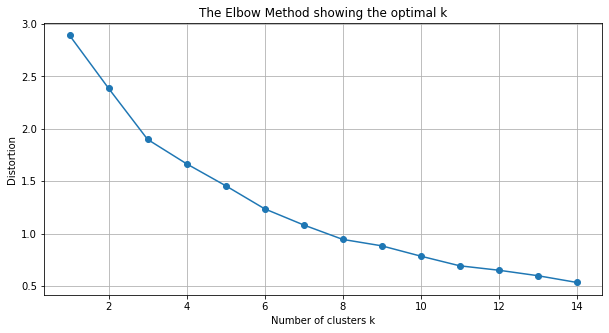

In [35]:
fig = plt.figure(figsize=(10, 5))
plt.plot(n_clusters, inertia, '-o')
plt.grid(True)

plt.xlabel('Number of clusters k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')

In [36]:
# set number of clusters
kclusters = 8

zurich_grouped_cluster = zurich_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, n_init=20).fit(zurich_grouped_cluster)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 2, 0, 2, 2, 2, 7, 1, 2], dtype=int32)

In [37]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

zurich_merged = df_neighbourhoods

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
zurich_merged = zurich_merged.join(neighborhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

zurich_merged.head() # check the last columns!

,District,Neighbourhood,Latitude,Longitude,n_venues,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,9,Altstetten,47.387403,8.486061,27,0,Supermarket,Bakery,Discount Store,Sandwich Place,French Restaurant,Café,Food,Plaza,Bus Station,Swiss Restaurant
1,10,Höngg,47.401660,8.497715,17,0,Bus Station,Grocery Store,Supermarket,Health & Beauty Service,Italian Restaurant,Discount Store,Fast Food Restaurant,Steakhouse,Pizza Place,Gas Station
2,11,Affoltern,47.418762,8.507186,13,0,Supermarket,Bus Station,Hotel,Department Store,Grocery Store,Gym / Fitness Center,Train Station,Light Rail Station,Athletics & Sports,Italian Restaurant
3,2,Wollishofen,47.342427,8.530708,13,0,Restaurant,Tram Station,Supermarket,Music Venue,Plaza,Salon / Barbershop,Cheese Shop,Bus Station,Swiss Restaurant,Irish Pub
4,3,Friesenberg,47.354922,8.500523,2,1,Stables,Tennis Court,Accessories Store,Optical Shop,Modern European Restaurant,Moroccan Restaurant,Movie Theater,Multiplex,Museum,Music Venue


## Examine clusters 



#### Cluster 1

In [40]:
for i in range(0,kclusters):
    print('\n Cluster {}'.format(i+1))
    display(zurich_merged.loc[zurich_merged['Cluster Labels'] == i, zurich_merged.columns[[1] + list(range(5, zurich_merged.shape[1]))]])


 Cluster 1


,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Altstetten,0,Supermarket,Bakery,Discount Store,Sandwich Place,French Restaurant,Café,Food,Plaza,Bus Station,Swiss Restaurant
1,Höngg,0,Bus Station,Grocery Store,Supermarket,Health & Beauty Service,Italian Restaurant,Discount Store,Fast Food Restaurant,Steakhouse,Pizza Place,Gas Station
2,Affoltern,0,Supermarket,Bus Station,Hotel,Department Store,Grocery Store,Gym / Fitness Center,Train Station,Light Rail Station,Athletics & Sports,Italian Restaurant
3,Wollishofen,0,Restaurant,Tram Station,Supermarket,Music Venue,Plaza,Salon / Barbershop,Cheese Shop,Bus Station,Swiss Restaurant,Irish Pub
5,Hottingen,0,Hotel,Tram Station,Swiss Restaurant,Italian Restaurant,Bakery,Bistro,Theater,Coffee Shop,Supermarket,History Museum
6,Witikon,0,Supermarket,Bus Station,Department Store,Indian Restaurant,Discount Store,Tram Station,Bakery,Grocery Store,Church,Outdoors & Recreation
7,Seebach,0,Hookah Bar,Tram Station,Plaza,Grocery Store,Laser Tag,Bakery,Pool,Korean Restaurant,Eastern European Restaurant,Supermarket
8,Albisrieden,0,Grocery Store,Pizza Place,Supermarket,Swiss Restaurant,Trattoria/Osteria,Bakery,Scenic Lookout,Accessories Store,Modern European Restaurant,Moroccan Restaurant
11,Schwamendingen-Mitte,0,Bus Station,Plaza,Shopping Mall,Fast Food Restaurant,Light Rail Station,Café,Tram Station,Swiss Restaurant,Asian Restaurant,Arts & Crafts Store
13,Oberstrass,0,Hotel,Tram Station,Supermarket,Italian Restaurant,Bus Station,Swiss Restaurant,Bakery,Hill,Restaurant,Park



 Cluster 2


,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Friesenberg,1,Stables,Tennis Court,Accessories Store,Optical Shop,Modern European Restaurant,Moroccan Restaurant,Movie Theater,Multiplex,Museum,Music Venue



 Cluster 3


,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,Oerlikon,2,Supermarket,Italian Restaurant,Hotel,Restaurant,Pub,Kebab Restaurant,Indian Restaurant,Coffee Shop,Mexican Restaurant,Café
14,Unterstrass,2,Café,Italian Restaurant,Middle Eastern Restaurant,Bakery,Bus Station,Grocery Store,Pizza Place,Pharmacy,Park,Falafel Restaurant
15,Seefeld,2,Italian Restaurant,Hotel,Art Museum,Restaurant,Café,Swiss Restaurant,Park,Salad Place,Supermarket,Bakery
16,Enge,2,Italian Restaurant,Hotel,Bar,Plaza,Supermarket,Café,Swiss Restaurant,Tram Station,Lounge,History Museum
18,Wipkingen,2,Italian Restaurant,Grocery Store,Japanese Restaurant,Breakfast Spot,Design Studio,Supermarket,Restaurant,Indian Restaurant,Pizza Place,Business Service
21,Alt-Wiedikon,2,Restaurant,Italian Restaurant,Playground,Light Rail Station,Supermarket,Diner,Burrito Place,Tapas Restaurant,Flower Shop,Thai Restaurant
22,Sihlfeld,2,Italian Restaurant,Café,Bar,Plaza,Supermarket,Ethiopian Restaurant,Hotel,Cocktail Bar,Cemetery,Coffee Shop
23,Hard,2,Hotel,Supermarket,Café,Plaza,Mediterranean Restaurant,Swiss Restaurant,Restaurant,Outdoors & Recreation,Peruvian Restaurant,Park
24,Escher Wyss,2,Café,Hotel,Restaurant,Bar,Nightclub,Gym / Fitness Center,Italian Restaurant,Bakery,Concert Hall,Hotel Bar
25,Langstrasse,2,Bar,Swiss Restaurant,Italian Restaurant,Restaurant,Café,Nightclub,Thai Restaurant,Mediterranean Restaurant,Chinese Restaurant,Middle Eastern Restaurant



 Cluster 4


,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
26,Saatlen,3,Supermarket,Arts & Crafts Store,Kebab Restaurant,Bagel Shop,Bus Station,Outdoors & Recreation,Moroccan Restaurant,Movie Theater,Multiplex,Museum



 Cluster 5


,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
19,Hirzenbach,4,Tram Station,Furniture / Home Store,Steakhouse,Accessories Store,Optical Shop,Modern European Restaurant,Moroccan Restaurant,Movie Theater,Multiplex,Museum



 Cluster 6


,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,Leimbach,5,Trail,Moroccan Restaurant,Gas Station,Tennis Court,Grocery Store,Meyhane,Modern European Restaurant,Movie Theater,Multiplex,Museum



 Cluster 7


,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
20,Weinegg,6,Modern European Restaurant,Swiss Restaurant,Restaurant,Farm,Other Great Outdoors,Moroccan Restaurant,Movie Theater,Multiplex,Museum,Music Venue



 Cluster 8


,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,Fluntern,7,Tram Station,Grocery Store,Bakery,Plaza,Supermarket,Gastropub,Bus Station,Pizza Place,Pedestrian Plaza,Music Venue
17,Hirslanden,7,Tram Station,Italian Restaurant,Plaza,Mediterranean Restaurant,Pizza Place,Steakhouse,Hotel,Swiss Restaurant,Park,Grocery Store


## Retrieve Zurich rental data

Retrieve data from https://realadvisor.ch/en/property-prices/city-zurich

I scrape the website of realadvisor to get the median prices per sqm per year for apartments in Zurichs neighbourhood.
For some reason directly scraping the table "Price per sqm for each neighbourhood in Zurich" was not possible: I could only retrieve all columns until the neighbourhood row City. After that only the neighbourhood was returned without rhe prices. Therefore I retrieve the links to each neighbourhood. Then I read the html address with BeautifulSoup again and retrieve the average price per sqm from there. Surely, more elegant ways exist, but since it is my first time scraping a website I chose what first came to mind..

In [42]:
# Url from website with the table
url = 'https://realadvisor.ch/en/property-prices/city-zurich'
html_content = requests.get(url).text
soup = BeautifulSoup(html_content, "html")
price_sqm_table = soup.findAll("div", attrs={"class": "css-5oyp9l"})[1]

# Now find all link in table and access it to retrieve the price
price_sqms = []
hoods = []
for i in range(0, len(price_sqm_table)):
    for td in price_sqm_table.tbody.find_all("a"):
        href = td.get("href")
        html_temp = requests.get(urljoin(url, href)).text
        soup_temp = BeautifulSoup(html_temp, "html")
        name = soup_temp.findAll("h1", attrs={"class": "css-3ek332"})[0].text
        
        price_sqm_tmp = soup_temp.findAll("div", attrs={"class": "css-qpxiip-MedianPrice"})[4]
        price_sqm_tmp = int(price_sqm_tmp.text.split('\xa0')[1])
        price_sqms.append(price_sqm_tmp)
        
        
        hood = name.split(':')[0]# href.split('/')[-1].split('-', maxsplit=1)
        hoods.append(hood)

In [55]:
price_sqm_dict = {
    "Neighbourhood": hoods,
    "Price": price_sqms
}

df_price_sqm = pd.DataFrame(price_sqm_dict)
df_price_sqm['Neighbourhood'] = df_price_sqm['Neighbourhood'].str.title()

In [59]:
zurich_merged_rent = zurich_merged.join(df_price_sqm.set_index('Neighbourhood'), on='Neighbourhood')

In [60]:
zurich_merged_rent.head(2)

,District,Neighbourhood,Latitude,Longitude,n_venues,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Price
0,9,Altstetten,47.387403,8.486061,27,0,Supermarket,Bakery,Discount Store,Sandwich Place,French Restaurant,Café,Food,Plaza,Bus Station,Swiss Restaurant,396
1,10,Höngg,47.401660,8.497715,17,0,Bus Station,Grocery Store,Supermarket,Health & Beauty Service,Italian Restaurant,Discount Store,Fast Food Restaurant,Steakhouse,Pizza Place,Gas Station,345


In [63]:
df_neighbourhoods = pd.read_csv('./data/stzh.adm_statistische_quartiere_v.csv')
# drop some columns and rename columns
df_neighbourhoods= df_neighbourhoods.drop(columns=['objid', 'qnr','knr', 'kname'], inplace=False)
print(type(df_neighbourhoods))
df_neighbourhoods=df_neighbourhoods.rename(columns={'qname': 'Neighbourhood', 'geometry': 'geometry'}, inplace=False)
zurich_merged_rent = zurich_merged_rent.join(df_neighbourhoods.set_index('Neighbourhood'), on='Neighbourhood')
#bla.head(2)

<class 'pandas.core.frame.DataFrame'>


In [79]:
zurich_merged_rent = zurich_merged_rent.rename(columns={'Cluster Labels': 'Cluster'}, inplace=False)

In [81]:
# create map of Toronto using latitude and longitude values
map_zurich = folium.Map(location=[latitude, longitude], zoom_start=11)
    
map_zurich.choropleth(
    geo_data=state_geo,
    name='choropleth',
    data=zurich_merged_rent,
    columns=['Neighbourhood', 'District'],
    key_on='feature.properties.qname',
    #fill_color='OrRd',
    fill_color='Paired',
    fill_opacity=0.7,
    line_opacity=0.7,
    legend_name='Districts',
    bins=12
)
#folium.LayerControl().add_to(map_zurich)

# add markers to map
for lat, lng, cluster, neighbourhood, n_venues, price in zip(
    zurich_merged_rent['Latitude'], zurich_merged_rent['Longitude'], 
    zurich_merged_rent['Cluster'], zurich_merged_rent['Neighbourhood'],
    zurich_merged_rent['n_venues'], zurich_merged_rent['Price']):
    
    label = '{}'.format(neighbourhood)
    label = folium.Popup(label, parse_html=True)
    
    # Add price on top
    icon = folium.DivIcon('<div style="font-size: 10">{}</div>'.format(str(price)))
    folium.Marker(
        location=[lat,lng],
        icon=icon
    ).add_to(map_zurich)
    
map_zurich